## plotNWT_hillslope_simple
#### Plots results from hillslope simulation
- Obs here are flux tower data, included in met forcing data
- Created by Will Wieder, Sept 28, 2021

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import utils
from scipy import signal,stats
import cftime
import nc_time_axis
import dask
#import cf_units as cf

# some resources for plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.lines as mlines
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from matplotlib.pyplot import cm

# suppress Runtime warnings that let you know when code isn't running too efficiently
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)
from distributed import wait

%matplotlib inline

In [2]:
# Updated for PBS scheduler
# this could go into utils.
# By default gets 1 core w/ 25 GB memory
def get_ClusterClient(ncores=1, nmem='25GB'):
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    ncores=ncores
    nmem = nmem

    cluster = PBSCluster(
        cores=ncores, # The number of cores you want
        memory=nmem, # Amount of memory
        processes=ncores, # How many processes
        queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
        resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
        project='P93300641', # Input your project ID here
        walltime='4:00:00', # Amount of wall time
        interface='ib0', # Interface to use
    )

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })

    client = Client(cluster)
    return cluster, client

In [3]:
cluster, client = get_ClusterClient(nmem='2GB')
cluster.scale(5)

In [4]:
cluster

### Point to files

In [5]:
# Niwot LTER  simulations
# H1 files dimensioned time x column or time x pft
site  = ['DM','MM']
longSite  =  ['dry meadow','moist meadow']#'dry_meadow'
#case  =  ['NEON_NIWO_hh_test']
case  =  ['NEON_NIWO_3col_dm01_newSoil_trans','NEON_NIWO_3col_mm01_newSoil_trans']
rollHour = -12  
years = range(2008,2020)
nmon  = 12

#OBSdir = '/glade/p/cgd/tss/people/wwieder/inputdata/single_point/datmdata_NWT_Tvan/'+longSite+'/'
#OBSfile = [OBSdir + str(years[i])+'-'+str(m+1).zfill(2)+'.nc' for i in range(len(years))  for m in range(nmon)]  
#OUTdir = OBSdir
#print(OBSfile)

dirIn = ['/glade/scratch/wwieder/archive/'+case[c]+'/lnd/hist/' for c in range(len(case))]
# dirIn = ['/glade/scratch/wwieder/'+case[c]+'/run/' for c in range(len(case))]
dmfiles = [dirIn[0] + case[0] +'.clm2.h1.'+str(years[i]) +'-01-01-00000.nc' \
           for i in range(len(years)) ]  
mmfiles = [dirIn[1] + case[1] +'.clm2.h1.'+str(years[i]) +'-01-01-00000.nc' \
           for i in range(len(years)) ]  
print(dmfiles[0])
print(mmfiles[0])

/glade/scratch/wwieder/archive/NEON_NIWO_3col_dm01_newSoil_trans/lnd/hist/NEON_NIWO_3col_dm01_newSoil_trans.clm2.h1.2008-01-01-00000.nc
/glade/scratch/wwieder/archive/NEON_NIWO_3col_mm01_newSoil_trans/lnd/hist/NEON_NIWO_3col_mm01_newSoil_trans.clm2.h1.2008-01-01-00000.nc


--- 
### Read in the dataset 
- get rid of extra dimensions
- remove CLM time shift

In [6]:
%%time
ds_dm = utils.time_set_mid(xr.open_mfdataset(dmfiles, decode_times=True, combine='by_coords'), 'time')
ds_mm = utils.time_set_mid(xr.open_mfdataset(mmfiles, decode_times=True, combine='by_coords'), 'time')
print('---- read  in data  ----')

---- read  in data  ----
CPU times: user 29.2 s, sys: 457 ms, total: 29.7 s
Wall time: 40 s


#### Combine pft and column coordinates, then combine datasets 

In [7]:
ds_dm = ds_dm.rename({'pft':'column'})
ds_mm = ds_mm.rename({'pft':'column'})
ds = ds_dm.where(ds_dm.column==2, ds_mm)

In [8]:
ds = ds.assign_coords({"column": ["mm", "wm", "dm"]})

### Time series plots in all three veg communities

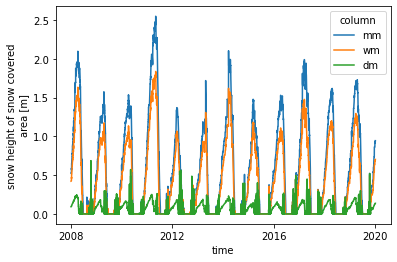

In [10]:
ds.SNOW_DEPTH.plot(hue='column') ;

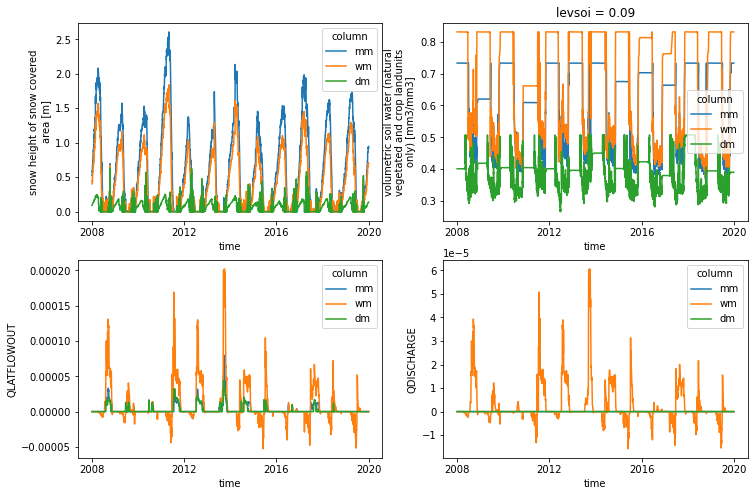

In [12]:
plt.figure(figsize=[12,8])
plt.subplot(221)
ds.SNOW_DEPTH.plot(hue='column') 
plt.subplot(222)
ds.isel(levsoi=2).H2OSOI.plot(hue='column');

plt.subplot(223)
ds.QLATFLOWOUT.resample(time='D').mean('time').plot(hue='column') ;
plt.subplot(224)
ds.QDISCHARGE.resample(time='D').mean('time').plot(hue='column') ;


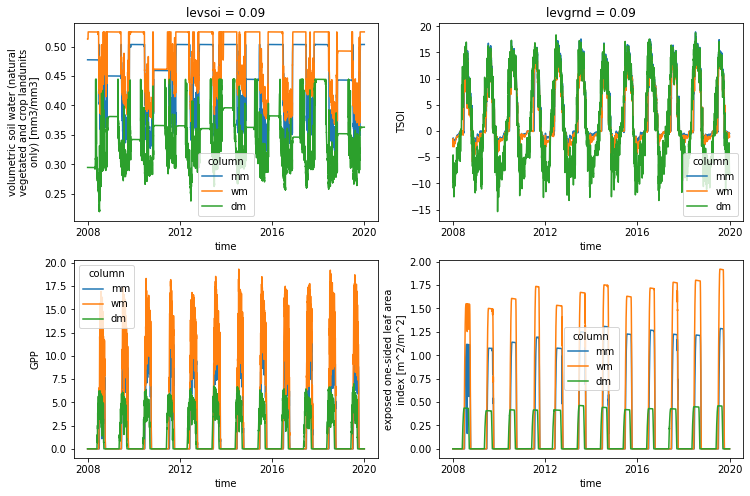

In [16]:
plt.figure(figsize=[12,8])

plt.subplot(221)
ds.isel(levsoi=2).H2OSOI.plot(hue='column');
plt.subplot(222)
(ds.isel(levgrnd=2).TSOI.resample(time='D').mean('time')-273.15).plot(hue='column');
plt.subplot(223)
(ds.GPP.resample(time='D').mean('time')*24*3600).plot(hue='column') ; #gC/m2/d
plt.subplot(224)
ds.ELAI.plot(hue='column');

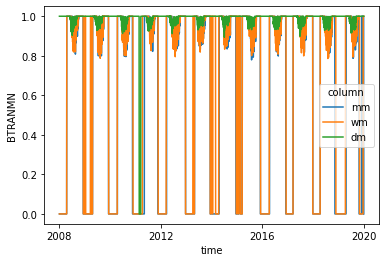

In [17]:
ds.BTRANMN.resample(time='D').mean('time').plot(hue='column') ; #.plot(hue='pft');
#ds.QDISCHARGE.isel(column=0).groupby('time.dayofyear').sum().values

gC/m^2/s


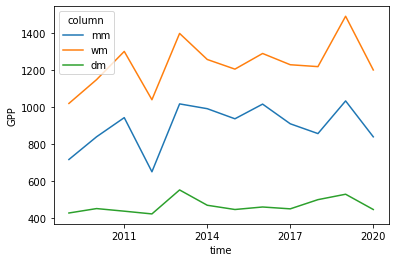

In [9]:
print(ds.GPP.attrs['units'])
(ds.GPP.resample(time='Y').mean('time')*365*24*3600).plot(hue='column') ;

In [ ]:
# Calculate and plot NPP
ds['NPP'] = ds.GPP - ds.AR
(ds.NPP.resample(time='Y').mean('time')*365*24*3600).plot(hue='column');

### Depth-resolved soil temperature and moisture plots

In [27]:
# Reverse axes here
ds['levsoi'] = ds.levsoi * -1

In [28]:
ds.levsoi 

<xarray.DataArray 'levsoi' (levsoi: 20)>
array([-0.01, -0.04, -0.09, -0.16, -0.26, -0.4 , -0.58, -0.8 , -1.06, -1.36,
       -1.7 , -2.08, -2.5 , -2.99, -3.58, -4.27, -5.06, -5.95, -6.94, -8.03],
      dtype=float32)
Coordinates:
  * levsoi   (levsoi) float32 -0.01 -0.04 -0.09 -0.16 ... -5.95 -6.94 -8.03

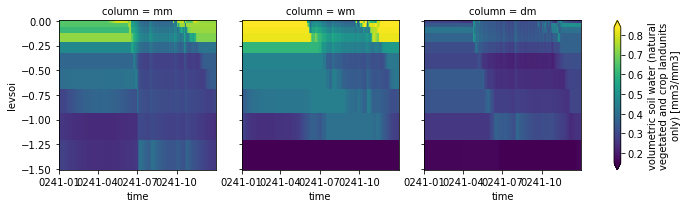

In [29]:
g_simple = ds.H2OSOI.isel(levsoi=slice(0,10)).plot(x="time", y="levsoi", col="column", col_wrap=3, robust=True)

In [30]:
ds['levgrnd'] = ds.levgrnd * -1

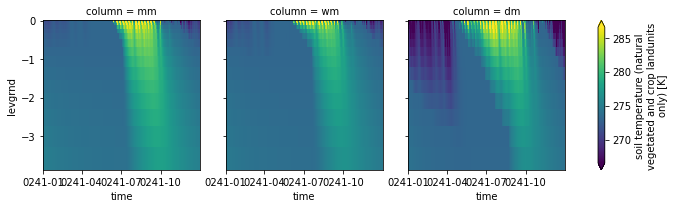

In [31]:
g_simple = ds.isel(levgrnd=slice(0,15)).TSOI.plot(x="time", y="levgrnd", col="column", col_wrap=3, robust=True)

---
### Reading in observations from the Saddle to compare with CLM simulations

In [9]:
nwtOBS = '/glade/p/cgd/tss/people/wwieder/inputdata/single_point/datmdata_NWT_Tvan/NWT_lter_obs_downloads/'
dsNET = pd.read_table(nwtOBS+'sensor_network_soil_data_30_min.txt')#.to_xarray()  # Saddle sensors
dsTVan = pd.read_table(nwtOBS+'tvan_soil_data_30_min.txt') # Tvan soil sensors
dsSNO = pd.read_table(nwtOBS+'saddle_grid_snow_depth_data_biweekly.txt') # Saddle snow 
dsNPP = pd.read_table(nwtOBS+'saddle_grid_productivity_data.txt')    # Saddle productivity

# add date-time
dsNET.date = pd.to_datetime(dsNET.date)
dsTVan.date = pd.to_datetime(dsTVan.date)
dsSNO.date = pd.to_datetime(dsSNO.date)
#dsNPP.date = pd.to_datetime(dsNPP.date)

# combine sensor data from saddle network and Tvan
dsSOI = pd.concat([dsNET,dsTVan]) 

In [10]:
# Aggregate data by date & vegetation community 
dsSOIgroup = dsSOI.groupby(['date','veg_com'])
dsSOIdaily = dsSOIgroup.aggregate(np.mean)
dsSOIdailySTD = dsSOIgroup.aggregate(np.std)

# This is already done for snowdepth, but now we'll get results dimensioned by date*veg_com
dsSNOgroup = dsSNO.groupby(['date','veg_com'])
dsSNOdaily = dsSNOgroup.aggregate(np.mean)

dsNPPgroup = dsNPP.groupby(['year','veg_com'])
dsNPPdaily = dsNPPgroup.aggregate(np.mean)
dsNPPdailySTD = dsNPPgroup.aggregate(np.std)

#### Converting Saddle network data to xarray

In [11]:
dsSOI = dsSOIdaily.to_xarray()
dsSOIstd = dsSOIdailySTD.to_xarray()
dsSNO = dsSNOdaily.to_xarray()
dsNPP = dsNPPdaily.to_xarray()
dsNPPstd = dsNPPdailySTD.to_xarray()

# reindex by veg community for plotting consistency
Veg = ["DM", "MM","WM"]
fullVeg = ["dry_meadow", "moist_meadow","wet_meadow"]
dsSOI = dsSOI.reindex({'veg_com': Veg})
dsSOIstd = dsSOIstd.reindex({'veg_com': Veg})
dsSNO = dsSNO.reindex({'veg_com': Veg})
dsNPP = dsNPP.reindex({'veg_com': Veg})
dsNPPstd = dsNPPstd.reindex({'veg_com': Veg})

# reindex CLM dataset by veg community
veg  = ["dm","mm","wm"]
ds = ds.reindex({'column': veg})

#### Plotting simulated and observed snow depth

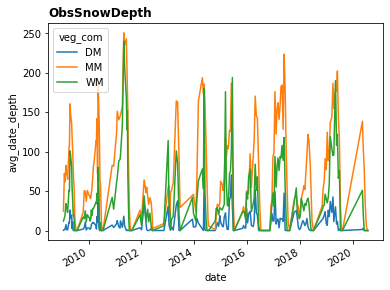

In [14]:
# Observed snow depth 2009-2020, all communities
dsSNO.where(dsSNO['date.year']>2008).avg_date_depth.plot(hue='veg_com');
plt.title('ObsSnowDepth', loc='left', fontsize='large', fontweight='bold');

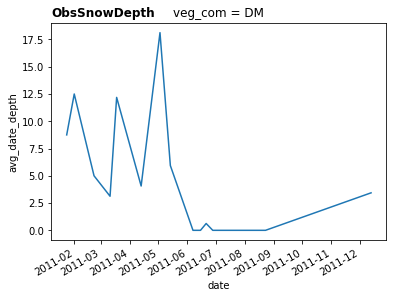

In [19]:
# Focus in on a specific year and veg community
dsSNO.sel(veg_com='DM').where(dsSNO['date.year']==2011).avg_date_depth.plot();
plt.title('ObsSnowDepth', loc='left', fontsize='large', fontweight='bold');

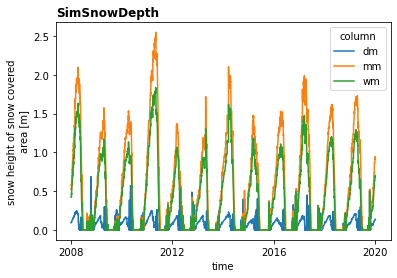

In [17]:
# Simulated snow depth 2008-2020, all communities
ds.SNOW_DEPTH.plot(hue='column') ;
plt.title('SimSnowDepth', loc='left', fontsize='large', fontweight='bold');

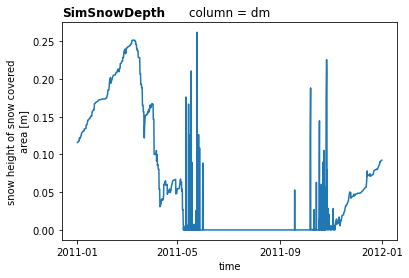

In [20]:
# Focus in on a specific year and veg community
ds.sel(column='dm').where(ds['time.year']==2011).SNOW_DEPTH.plot() ;
plt.title('SimSnowDepth', loc='left', fontsize='large', fontweight='bold');

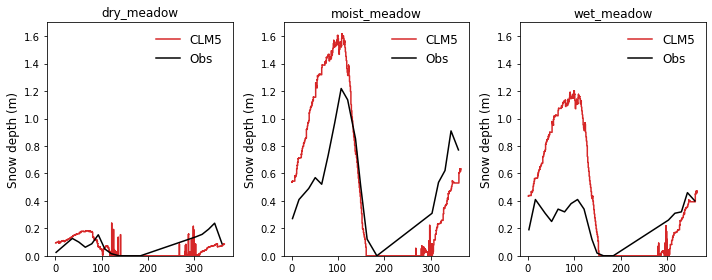

In [14]:
# Plot observed and simulated snow depth together for all 3 communities for a given year

plotYear =  2018

fig, axs = plt.subplots(1, len(ds.column), figsize=(10,4))

for i in range(len(ds.column)):
    x = ds['time.dayofyear'].where(ds['time.year']==plotYear)
    x2 = dsSNO['date.dayofyear'].where(dsSNO['date.year']==plotYear)

    y = ds.isel(column=i).where(ds['time.year']==plotYear).SNOW_DEPTH
    y2 = dsSNO.isel(veg_com=i).where(dsSNO['date.year']==plotYear).avg_date_depth/100

    axs[i].plot(x, y, color='tab:red')
    axs[i].plot(x2, y2, color='k')

    axs[i].set_ylim([0, 1.7])
    axs[i].set_ylabel('Snow depth (m)', fontsize='large')    
    axs[i].set_title(fullVeg[i])
    
    axs[i].legend(('CLM5','Obs'), frameon=False,fontsize='large')

fig.tight_layout()
plt.show()

#### Plotting observed and simulated soil temperature and moisture

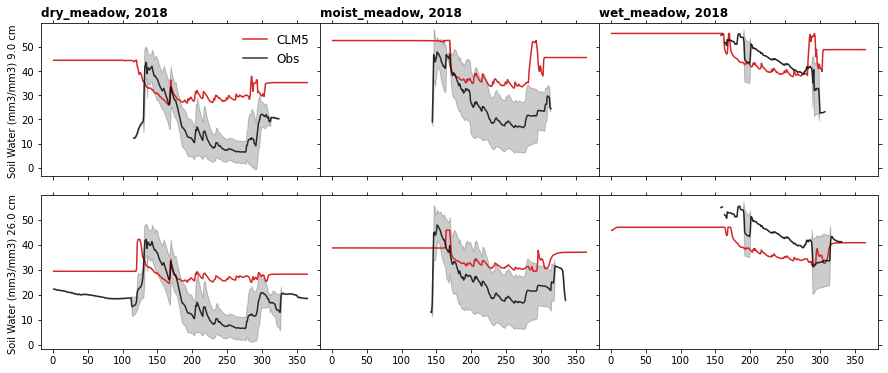

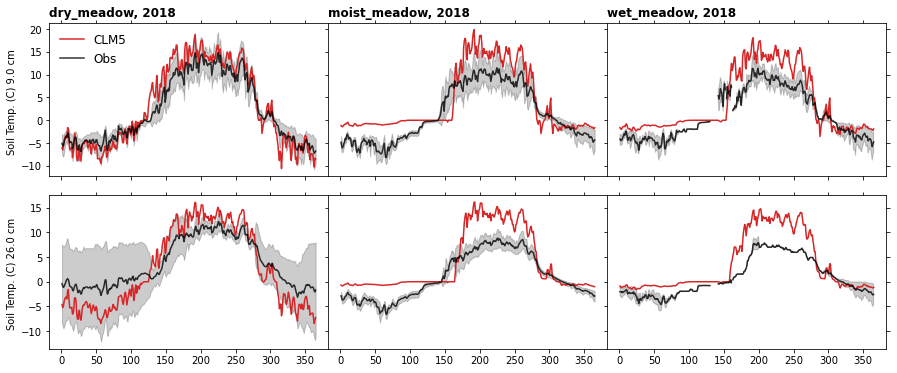

In [23]:
nyear = len(years) 
clmVARS = ['H2OSOI','TSOI']
obsVARSu = ['soilmoisture_upper_avg','soiltemp_upper_avg']
obsVARSl = ['soilmoisture_lower_avg','soiltemp_lower_avg']
plotYear =  2018

for v in range(len(clmVARS)):
    fig, axs = plt.subplots(2, len(Veg), 
                        sharey='row', sharex=True,
                        gridspec_kw={'wspace': 0, 'hspace': 0.12},
                        figsize=(15,6))    
    for i in range(len(Veg)):
        for j in range(2):
            if i == 0: 
                nlev = 2 #10 cm for fell field
            else: 
                nlev = 1 # 5 cm for sensor network
            if j == 1: nlev = 4

            # Select data to plot    
            x = ds['time.dayofyear'].where(ds['time.year']==plotYear)
            x2 = dsSOI['date.dayofyear'].where(dsSOI['date.year']==plotYear)

            if v == 0:
                y = ds[clmVARS[v]].isel(levsoi=nlev,column=i).where(ds['time.year']==plotYear).groupby(x).mean() * 100
            else:
                y = ds[clmVARS[v]].isel(levgrnd=nlev,column=i).where(ds['time.year']==plotYear).groupby(x).mean() -273.15
            
            if j == 0: 
                y2 = dsSOI[obsVARSu[v]].isel(veg_com=i).where(dsSOI['date.year']==plotYear)
                ySTD = dsSOIstd[obsVARSu[v]].isel(veg_com=i).where(dsSOI['date.year']==plotYear)
            if j == 1: 
                y2 = dsSOI[obsVARSl[v]].isel(veg_com=i).where(dsSOI['date.year']==plotYear)
                ySTD = dsSOIstd[obsVARSl[v]].isel(veg_com=i).where(dsSOI['date.year']==plotYear)
            x = x.groupby(x).mean()
            
            axs[j,i].plot(x, y, '-',color='tab:red')
            axs[j,i].plot(x2, y2, '-', color='k', alpha=0.8)
            axs[j,i].fill_between(x2, y2-ySTD, y2+ySTD, alpha=0.2,color='k')
            axs[j,i].yaxis.set_ticks_position('both')# Ticks on all 4 sides                                                                                                                                                                                                                                    
            axs[j,i].xaxis.set_ticks_position('both')     


            # control titles & axis labels
            # label columns of data with variable names
            depth = str(np.round(ds["levgrnd"].isel(levgrnd=nlev).values * 100,0))
            if j == 0:
                axs[j,i].set_title(fullVeg[i]+", "+str(plotYear), 
                                   loc='left', fontsize='large', fontweight='bold')
                if i == 0 :
                    axs[j,i].legend(('CLM5','Obs'), frameon=False,fontsize='large')
            #if j == 1:
                #axs[j,i].set_title(depth + " cm ", loc='left', fontsize='large', fontweight='bold')
            if i == 0:
                if v == 0:
                    axs[j,i].set_ylabel('Soil Water (mm3/mm3) '+depth+ " cm ");
                else:
                    axs[j,i].set_ylabel('Soil Temp. (C) '+depth+ " cm ");

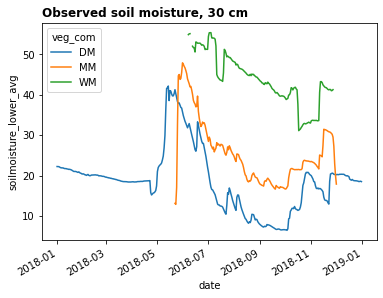

In [17]:
dsSOI.where(dsSOI['date.year']==2018).soilmoisture_lower_avg.plot(hue='veg_com');
plt.title('Observed soil moisture, 30 cm', loc='left', fontsize='large', fontweight='bold');

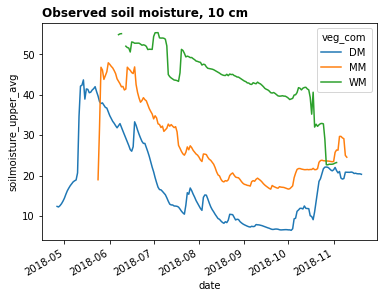

In [40]:
dsSOI.where(dsSOI['date.year']==2018).soilmoisture_upper_avg.plot(hue='veg_com');
plt.title('Observed soil moisture, 10 cm', loc='left', fontsize='large', fontweight='bold');

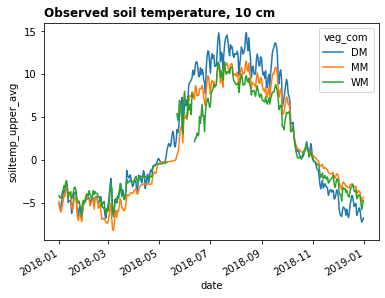

In [20]:
dsSOI.where(dsSOI['date.year']==2018).soiltemp_upper_avg.plot(hue='veg_com');
plt.title('Observed soil temperature, 10 cm', loc='left', fontsize='large', fontweight='bold');

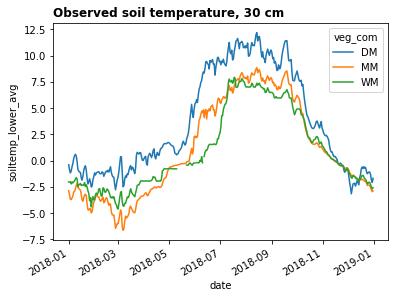

In [21]:
dsSOI.where(dsSOI['date.year']==2018).soiltemp_lower_avg.plot(hue='veg_com');
plt.title('Observed soil temperature, 30 cm', loc='left', fontsize='large', fontweight='bold');

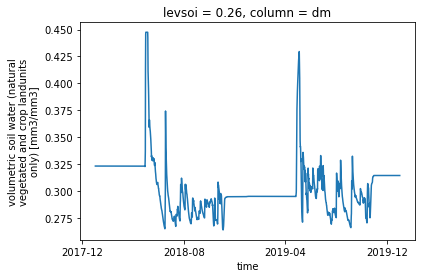

In [34]:
ds.isel(levsoi=4).sel(column='dm').where(ds.H2OSOI['time.year']>2017).H2OSOI.plot(hue='column');

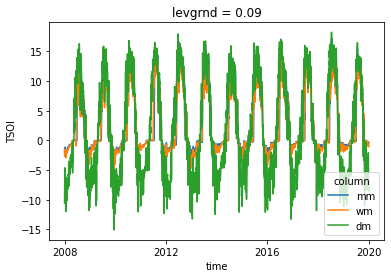

In [33]:
(ds.isel(levgrnd=2).TSOI.resample(time='D').mean('time')-273.15).plot(hue='column');

---
### Reading in Tvan flux tower data to compare with simulated fluxes

#### Point to files 

In [15]:
longSite  =  'dry_meadow'
years = range(2008,2020)
nmon  = 12
OBSdir = '/glade/p/cgd/tss/people/wwieder/inputdata/single_point/datmdata_NWT_Tvan/'+longSite+'/'
OBSfile = [OBSdir + str(years[i])+'-'+str(m+1).zfill(2)+'.nc' for i in range(len(years))  for m in range(nmon)]  
OUTdir = OBSdir
#print(OBSfile)

#### Read in Tvan data

In [16]:
dsOBS = utils.time_set_mid(xr.open_mfdataset(OBSfile, decode_times=True, combine='by_coords'), 'time')

In [15]:
# Now remove extra dimensions & coordinates
dsOBS  = dsOBS.isel(lat=0, lon=0)

# Remove CLM time shift
ds  = ds.isel(lndgrid=0)
ds = ds.shift(time=-1)

In [16]:
# Calculate Rnet from absorbed - reflected radiation
ds['Rnet'] = ds.FSA - ds.FIRA	
ds['Rnet'].attrs['units'] = ds.FSA.attrs['units']
ds['Rnet'].attrs['long_name'] = 'net radiation'

In [17]:
# Calculate latent heat flux
ds['EFLX_LH_TOT'] = ds.FCEV + ds.FCTR + ds.FGEV
#print(ds.EFLX_LH_TOT)
# some negative values

In [18]:
# Convert observed GPP units from umol/m2/s to g/m2/h
# Assumes NEON results are umolC (not CO2) m^-2 s^-1
dsOBS['GPP'] = dsOBS.GPP * 1e-6 * 12.01 * 3600
dsOBS['GPP'].attrs['units'] = 'gC/m2/h'

# Now convert CLM GPP units from g/m2/s to g/m2/h
ds['GPP'] = ds.GPP * 3600
ds['GPP'].attrs['units'] = 'gC/m2/h'

### Plotting seasonal patterns in fluxes

In [19]:
# Create new variables to subset by season
dsOBS['season'] = dsOBS['time.season']
ds['season'] = ds['time.season']

Var = ['Rnet','FSH','EFLX_LH_TOT','GPP']
Season = ['DJF','MAM','JJA','SON']

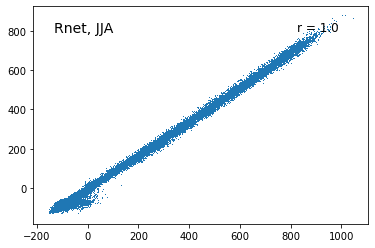

In [22]:
# Quick look at one variable and season

fig, ax = plt.subplots()
x, y = dsOBS[Var[0]].where(dsOBS.season==Season[2]).values,  \
    ds[Var[0]][:,0].where(ds.season==Season[2]).values

ax.plot(x, y,',')
line = mlines.Line2D([x.min(), x.max()], [x.min(), x.max()], color='k')
ax.add_line(line)
ax.text(0.15, 0.90,(Var[0]+', '+Season[2]), fontsize=14, 
        ha='center', va='center', transform=plt.gca().transAxes);

# drop missing values from x,y
bad = ~np.logical_or(np.isnan(x), np.isnan(y))
x = np.compress(bad, x)  
y = np.compress(bad, y) 

R, p = stats.pearsonr(x,y)
R = np.round(R, 2)
ax.text(0.85, 0.90,'r = '+str(R),fontsize=12, 
        ha='center', va='center', transform=plt.gca().transAxes);

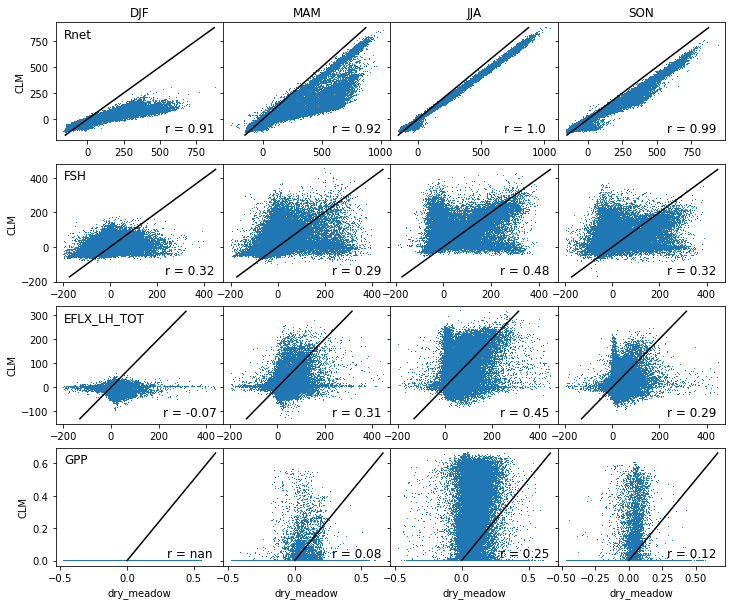

In [32]:
# Now plot all variables and seasons

fig, axs = plt.subplots(len(Var), len(Season), sharey='row', #sharey='col',
                        gridspec_kw={'wspace': 0},
                        figsize=(12,10))
for v in range(len(Var)):
    ymin = ds[Var[v]][:,0].min()
    ymax = ds[Var[v]][:,0].max()
    for i in range(len(Season)):
        x = dsOBS[Var[v]].where(dsOBS.season==Season[i]).values
        y = ds[Var[v]][:,0].where(ds.season==Season[i]).values
        axs[v,i].plot(x, y,',')
        line = mlines.Line2D([ymin, ymax], [ymin, ymax], color='k')
        axs[v,i].add_line(line)

        # add stats
        bad = ~np.logical_or(np.isnan(x), np.isnan(y))
        x = np.compress(bad, x)  
        y = np.compress(bad, y) 
        R, p = stats.pearsonr(x,y)
        R = np.round(R, 2)
        axs[v,i].text(0.8, 0.1,'r = '+str(R),fontsize=12, 
                     ha='center', va='center', transform=axs[v,i].transAxes)

        # control titles & axis labels
        # label colums of data with variable name
        if v == 0: 
            axs[v, i].set_title(Season[i])
            #axs[v,i].text(0.15, 0.90,(Season[i]), fontsize=12, ha='center', va='center', 
            #    transform=axs[v,i].transAxes)
          #  if i == 0:
           #     axs[i, v].set_title(site[0], loc='left', 
            #                        fontsize='x-large', fontweight='bold')

        # x-axis lables on bottom row of plots
        if v == 3: 
            axs[v, i].set_xlabel(longSite)
        
        # y axis labels and seasons in left column
        if i == 0:
            axs[v,i].set_ylabel('CLM')
            axs[v,i].text(0.05, 0.90,(Var[v]), fontsize=12, ha='left', va='center', 
                transform=axs[v,i].transAxes)

#plt.savefig(OUTdir+site[0]+'_FluxScatter.pdf');

### Plotting diel flux cycle

In [20]:
# Can't groupby hour & minutes, so first combine them here
dsOBS['HourMin'] = np.round(dsOBS['time.hour'] + dsOBS['time.minute']/60,1)
ds['HourMin'] = np.round(ds['time.hour'] + ds['time.minute']/60,1)
dsOBS['MonDay'] = np.round(dsOBS['time.month'] + dsOBS['time.day']/100,2)
ds['MonDay'] = np.round(ds['time.month'] + ds['time.day']/100,2)

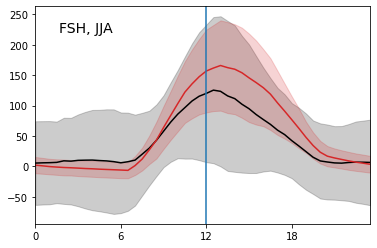

In [80]:
# Quick look at one variable and season
v, i = 0, 2
obsX = dsOBS[Var[v]].where(dsOBS.season==Season[i]).groupby(dsOBS['HourMin']).mean().roll(HourMin=rollHour, roll_coords=False)
clmX = ds[Var[v]][:,2].where(ds.season==Season[i]).groupby(dsOBS['HourMin']).mean().roll(HourMin=rollHour, roll_coords=False)
obsSD = dsOBS[Var[v]].where(dsOBS.season==Season[i]).groupby(dsOBS['HourMin']).std().roll(HourMin=rollHour, roll_coords=False)
clmSD = ds[Var[v]][:,2].where(ds.season==Season[i]).groupby(dsOBS['HourMin']).std().roll(HourMin=rollHour, roll_coords=False)

fig, ax = plt.subplots()
ax.plot(obsX.HourMin, obsX, '-', color='k')
ax.fill_between(obsX.HourMin, obsX - obsSD, obsX + obsSD, alpha=0.2,color='k')
ax.plot(clmX.HourMin, clmX, '-',color='tab:red')
ax.fill_between(clmX.HourMin, clmX - clmSD, clmX + clmSD, alpha=0.2,color='tab:red')
ax.text(0.15, 0.90,(Var[v]+', '+Season[i]), fontsize=14, 
        ha='center', va='center', transform=plt.gca().transAxes);
ax.axvline(x=12)
plt.xlim(0,23.5)
plt.xticks(np.arange(0., 24., 6.0));

In [ ]:
# Now plot all variables and seasons
# This takes a really long time to run

fig, axs = plt.subplots(len(Var), len(Season), 
                        sharey='row', sharex=True,
                        gridspec_kw={'wspace': 0, 'hspace': 0},
                        figsize=(12,10))
for v in range(len(Var)):
    xmin = dsOBS[Var[v]].min()
    xmax = dsOBS[Var[v]].max()
    for i in range(len(Season)):
        # maybe use resample, not grouby, 
        # eg da.resample(time='1D').mean()
        obsX = dsOBS[Var[v]].where(dsOBS.season==Season[i]).groupby(dsOBS['HourMin']).mean().roll(HourMin=rollHour, roll_coords=False)
        clmX = ds[Var[v]][:,0].where(ds.season==Season[i]).groupby(dsOBS['HourMin']).mean().roll(HourMin=rollHour, roll_coords=False)
        obsSD = dsOBS[Var[v]].where(dsOBS.season==Season[i]).groupby(dsOBS['HourMin']).std().roll(HourMin=rollHour, roll_coords=False)
        clmSD = ds[Var[v]][:,0].where(ds.season==Season[i]).groupby(dsOBS['HourMin']).std().roll(HourMin=rollHour, roll_coords=False)
        clmX2 = ds[Var[v]][:,2].where(ds.season==Season[i]).groupby(dsOBS['HourMin']).mean().roll(HourMin=rollHour, roll_coords=False)
        clmSD2 = ds[Var[v]][:,2].where(ds.season==Season[i]).groupby(dsOBS['HourMin']).std().roll(HourMin=rollHour, roll_coords=False)

        axs[v,i].plot(obsX.HourMin, obsX, '-', color='k')
        axs[v,i].fill_between(obsX.HourMin, obsX - obsSD, obsX + obsSD, alpha=0.2,color='k')
        axs[v,i].plot(clmX.HourMin, clmX, '-',color='tab:red')
        axs[v,i].fill_between(clmX.HourMin, clmX - clmSD, clmX + clmSD, alpha=0.2,color='tab:red')
        axs[v,i].plot(clmX2.HourMin, clmX2, '-', color='tab:blue')
        axs[v,i].fill_between(clmX2.HourMin, clmX2 - clmSD2, clmX2 + clmSD2, alpha=0.2,color='tab:blue')
        axs[v,i].yaxis.set_ticks_position('both')# Ticks on all 4 sides                                                                                                                                                                                                                                    
        axs[v,i].xaxis.set_ticks_position('both')     

        # control titles & axis labels
        # label colums of data with variables name
        if v == 0: 
            axs[v, i].set_title(Season[i])
            if i == 0:
                axs[v,i].legend([longSite,'CLM5_drymeadow','CLM5_wetmeadow'], frameon=False)
              #  axs[v,i].set_title(site[0], loc='left', 
                   #                 fontsize='x-large', fontweight='bold')

        # x-axis lables on bottom row of plots
        if v == 3: 
            axs[v, i].set_xlabel('hour')
        
        # y axis labels and seasons in left column
        if i == 0:
            axs[v,i].set_ylabel(Var[v]) 

plt.xlim(0,23.5)
plt.xticks(np.arange(0., 24., 6.0))
#axs[0,0].legend((network+' '+longSite),'CLM5', frameon=False)

#plt.savefig(OUTdir+site[0]+'_FluxDiel.pdf');

### Plotting mean annual cycles

ConversionError: Failed to convert value(s) to axis units: <xarray.DataArray 'time' (MonDay: 365)>
array([cftime.DatetimeNoLeap(2008, 1, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2008, 1, 2, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2008, 1, 3, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2008, 1, 4, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2008, 1, 5, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2008, 1, 6, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2008, 1, 7, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2008, 1, 8, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2008, 1, 9, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2008, 1, 10, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2008, 1, 11, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2008, 1, 12, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2008, 1, 13, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2008, 1, 14, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2008, 1, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2008, 1, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2008, 1, 17, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2008, 1, 18, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2008, 1, 19, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2008, 1, 20, 0, 0, 0, 0, has_year_zero=True),
...
       cftime.DatetimeNoLeap(2008, 12, 13, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2008, 12, 14, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2008, 12, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2008, 12, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2008, 12, 17, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2008, 12, 18, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2008, 12, 19, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2008, 12, 20, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2008, 12, 21, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2008, 12, 22, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2008, 12, 23, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2008, 12, 24, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2008, 12, 25, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2008, 12, 26, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2008, 12, 27, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2008, 12, 28, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2008, 12, 29, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2008, 12, 30, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2008, 12, 31, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
    lat      float64 40.05
    lon      float64 105.6
  * MonDay   (MonDay) float64 1.01 1.02 1.03 1.04 ... 12.28 12.29 12.3 12.31

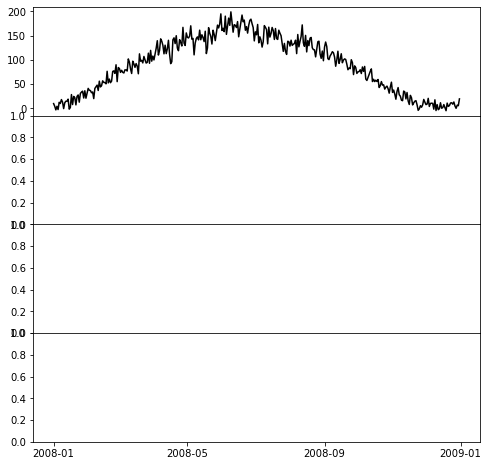

In [25]:
# This is not working yet

months = mdates.MonthLocator()  # every month
months_fmt = mdates.DateFormatter('%b')

fig, axs = plt.subplots(len(Var),1, sharex=True,
                        gridspec_kw={'wspace': 0, 'hspace': 0},
                        figsize=(8,8))
for v in range(len(Var)):
    # using groupby('time.dayofyear') gives too many days in leap year
    # use variable MonDay  instead
    x = dsOBS['time'].groupby(dsOBS.MonDay).min()
    obsX = dsOBS[Var[v]].groupby(dsOBS.MonDay).mean()
    clmX = ds[Var[v]][:,0].groupby(dsOBS.MonDay).mean()
    obsSD = dsOBS[Var[v]].groupby(dsOBS.MonDay).std()
    clmSD = ds[Var[v]][:,0].groupby(dsOBS.MonDay).std()
        
    axs[v].plot(x, obsX, '-', color='k')
    axs[v].fill_between(x, obsX - obsSD, obsX + obsSD, alpha=0.2,color='k')
    axs[v].plot(x, clmX, '-',color='tab:red')
    axs[v].fill_between(x, clmX - clmSD, clmX + clmSD, alpha=0.2,color='tab:red')
    axs[v].set_ylabel(Var[v])       
    axs[v].yaxis.set_ticks_position('both')# Ticks on all 4 sides                                                                                                                                                                                                                                    
    axs[v].xaxis.set_ticks_position('both')     

    # set  x axis limits
    axs[v].format_xdata = mdates.DateFormatter('%Y-%m-%d')
    axs[v].xaxis.set_major_locator(months)
    axs[v].xaxis.set_major_formatter(months_fmt)
    datemin = np.datetime64(x[0].values, 'm')
    datemax = np.datetime64(x[-1].values, 'm') 
    axs[v].set_xlim(datemin, datemax)

    # control titles & axis labels
    #if v == 0: 
      #  axs[v].set_title(site[0], loc='left', fontsize='x-large', fontweight='bold')

plt.legend([longSite,'CLM5'], frameon=False)

#fig.autofmt_xdate()
#plt.savefig(OUTdir+site[0]+'_FluxAnnual.pdf');